# Environment creation

In [167]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, avg, round
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType, IntegerType
import pandas as pd

In [168]:
spark = SparkSession.builder.appName("BigDataProject").getOrCreate()

In [169]:
df = spark.read.option('header', True).csv('/home/olzhasalimseitov/anaconda3/envs/big_data_project/weather/weather_kz.csv')

In [170]:
df.show()

+------+----+-----+----+-------------+---------------+-----------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|  city|date|month|year|weather_night|weather_morning|weather_day|weather_evening|temp_night|temp_morning|temp_day|temp_evening|press_night|press_morning|press_day|press_evening|hum_night|hum_morning|hum_day|hum_evening|
+------+----+-----+----+-------------+---------------+-----------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|Astana|  07|   02|2018|     пасмурно|       пасмурно|       ясно|    малооблачно|      -14°|        -13°|    -11°|        -13°|        768|          775|      782|          783|      81%|        84%|    92%|        84%|
|Astana|  06|   02|2018|  малооблачно|       пасмурно|   пасмурно|           ясно|      -19°|        -20°|    -14°| 

# Data pre-processing

In [171]:
full_labels = {
    'hum': 'humidity',
    'press': 'atmospheric pressure',
    'temp': 'temperature',
}
daytimes = ('night', 'morning', 'day', 'evening')

In [172]:
df.dropDuplicates(['weather_night']).select('weather_night').show()

+---------------+
|  weather_night|
+---------------+
|          дождь|
|           смог|
|           снег|
|          туман|
|        облачно|
|       пасмурно|
|          гроза|
|небольшой дождь|
|    малооблачно|
|           пыль|
|   легкий туман|
|           ясно|
+---------------+



In [173]:
translator = {
    'дождь': 'rainy',
    'смог': 'smoggy',
    'снег': 'snowy',
    'туман': 'foggy',
    'облачно': 'cloudy',
    'пасмурно': 'overcast',
    'гроза': 'stormy',
    'небольшой дождь': 'light rain',
    'малооблачно': 'partly cloudy',
    'пыль': 'dusty',
    'легкий туман': 'light fog',
    'ясно': 'clear',
}

df = df.replace(to_replace=translator, subset=['weather_night', 'weather_morning', 'weather_day', 'weather_evening'])

In [174]:
df.dropDuplicates(['weather_morning']).select('weather_morning').show()

+---------------+
|weather_morning|
+---------------+
|          rainy|
|          dusty|
|          snowy|
|      light fog|
|         stormy|
|  partly cloudy|
|     light rain|
|          clear|
|         cloudy|
|         smoggy|
|       overcast|
|          foggy|
+---------------+



In [175]:
print(f'Shape: ({df.count()}, {len(df.columns)})')

Shape: (36640, 20)


In [176]:
df.show()

+------+----+-----+----+-------------+---------------+-------------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|  city|date|month|year|weather_night|weather_morning|  weather_day|weather_evening|temp_night|temp_morning|temp_day|temp_evening|press_night|press_morning|press_day|press_evening|hum_night|hum_morning|hum_day|hum_evening|
+------+----+-----+----+-------------+---------------+-------------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|Astana|  07|   02|2018|     overcast|       overcast|        clear|  partly cloudy|      -14°|        -13°|    -11°|        -13°|        768|          775|      782|          783|      81%|        84%|    92%|        84%|
|Astana|  06|   02|2018|partly cloudy|       overcast|     overcast|          clear|      -19°|        -20°|

In [177]:
print(*set([df.select('city').where(col(column).isNull()).count() for column in df.columns]))

0


In [178]:
def temperature_formatter(temp):
    if temp[0] == '+':
      return temp[1:-1]
    elif temp[0] == '-':
      return temp[:-1]
    return temp[0]
udf_temperature_formmater = udf(lambda x: temperature_formatter(x), StringType())

In [179]:
df.select(udf_temperature_formmater(col('temp_night')).alias('temp_night')).show()

+----------+
|temp_night|
+----------+
|       -14|
|       -19|
|       -24|
|       -13|
|       -20|
|       -13|
|       -23|
|       -25|
|       -12|
|       -15|
|       -14|
|       -16|
|       -17|
|       -22|
|       -16|
|       -12|
|       -14|
|       -14|
|       -14|
|       -21|
+----------+
only showing top 20 rows



In [180]:
df.columns

['city',
 'date',
 'month',
 'year',
 'weather_night',
 'weather_morning',
 'weather_day',
 'weather_evening',
 'temp_night',
 'temp_morning',
 'temp_day',
 'temp_evening',
 'press_night',
 'press_morning',
 'press_day',
 'press_evening',
 'hum_night',
 'hum_morning',
 'hum_day',
 'hum_evening']

In [181]:
df = df.withColumn(
      'temp_night1', udf_temperature_formmater(df.temp_night)
      ).withColumn(
      'temp_morning1', udf_temperature_formmater(df.temp_morning)
      ).withColumn(
      'temp_day1', udf_temperature_formmater(df.temp_day)
      ).withColumn(
      'temp_evening1', udf_temperature_formmater(df.temp_evening)
      ).select('city',
        'date',
        'month',
        'year',
        'weather_night',
        'weather_morning',
        'weather_day',
        'weather_evening',
        col('temp_night1').alias('temp_night'),
        col('temp_morning1').alias('temp_morning'),
        col('temp_day1').alias('temp_day'),
        col('temp_evening1').alias('temp_evening'),
        'press_night',
        'press_morning',
        'press_day',
        'press_evening',
        'hum_night',
        'hum_morning',
        'hum_day',
        'hum_evening')

In [182]:
df.show()

+------+----+-----+----+-------------+---------------+-------------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|  city|date|month|year|weather_night|weather_morning|  weather_day|weather_evening|temp_night|temp_morning|temp_day|temp_evening|press_night|press_morning|press_day|press_evening|hum_night|hum_morning|hum_day|hum_evening|
+------+----+-----+----+-------------+---------------+-------------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|Astana|  07|   02|2018|     overcast|       overcast|        clear|  partly cloudy|       -14|         -13|     -11|         -13|        768|          775|      782|          783|      81%|        84%|    92%|        84%|
|Astana|  06|   02|2018|partly cloudy|       overcast|     overcast|          clear|       -19|         -20|

In [183]:
df.dropDuplicates(['temp_morning']).select('temp_morning').show()

+------------+
|temp_morning|
+------------+
|          -4|
|         -30|
|           7|
|          -1|
|          15|
|          -6|
|          11|
|          29|
|         -39|
|           3|
|          30|
|          34|
|           8|
|          -7|
|          22|
|          28|
|          16|
|          35|
|         -22|
|           0|
+------------+
only showing top 20 rows



In [184]:
def humidity_formatter(hum):
    return hum[:-1]
udf_thumidity_formmater = udf(lambda x: humidity_formatter(x), StringType())

In [185]:
df = df.withColumn(
      'hum_night1', udf_thumidity_formmater(df.hum_night)
      ).withColumn(
      'hum_morning1', udf_thumidity_formmater(df.hum_morning)
      ).withColumn(
      'hum_day1', udf_thumidity_formmater(df.hum_day)
      ).withColumn(
      'hum_evening1', udf_thumidity_formmater(df.hum_evening)
      ).select('city',
        'date',
        'month',
        'year',
        'weather_night',
        'weather_morning',
        'weather_day',
        'weather_evening',
        col('hum_night1').alias('hum_night'),
        col('hum_morning1').alias('hum_morning'),
        col('hum_day1').alias('hum_day'),
        col('hum_evening1').alias('hum_evening'),
        'press_night',
        'press_morning',
        'press_day',
        'press_evening',
        'temp_night',
        'temp_morning',
        'temp_day',
        'temp_evening')

In [186]:
df.show()

+------+----+-----+----+-------------+---------------+-------------+---------------+---------+-----------+-------+-----------+-----------+-------------+---------+-------------+----------+------------+--------+------------+
|  city|date|month|year|weather_night|weather_morning|  weather_day|weather_evening|hum_night|hum_morning|hum_day|hum_evening|press_night|press_morning|press_day|press_evening|temp_night|temp_morning|temp_day|temp_evening|
+------+----+-----+----+-------------+---------------+-------------+---------------+---------+-----------+-------+-----------+-----------+-------------+---------+-------------+----------+------------+--------+------------+
|Astana|  07|   02|2018|     overcast|       overcast|        clear|  partly cloudy|       81|         84|     92|         84|        768|          775|      782|          783|       -14|         -13|     -11|         -13|
|Astana|  06|   02|2018|partly cloudy|       overcast|     overcast|          clear|       75|         85|  

In [187]:
df = df.withColumn(
    "hum_night1", df.hum_night.cast(IntegerType())
    ).withColumn(
    "hum_morning1", df.hum_morning.cast(IntegerType())
    ).withColumn(
    "hum_day1", df.hum_day.cast(IntegerType())
    ).withColumn(
    "hum_evening1", df.hum_evening.cast(IntegerType())
    ).withColumn(
    "press_night1", df.press_night.cast(IntegerType())
    ).withColumn(
    "press_morning1", df.press_morning.cast(IntegerType())
    ).withColumn(
    "press_day1", df.press_day.cast(IntegerType())
    ).withColumn(
    "press_evening1", df.press_evening.cast(IntegerType())
    ).withColumn(
    "temp_night1", df.temp_night.cast(IntegerType())
    ).withColumn(
    "temp_morning1", df.temp_morning.cast(IntegerType())
    ).withColumn(
    "temp_day1", df.temp_day.cast(IntegerType())
    ).withColumn(
    "temp_evening1", df.temp_evening.cast(IntegerType())
    ).select('city',
        'date',
        'month',
        'year',
        'weather_night',
        'weather_morning',
        'weather_day',
        'weather_evening',
        col('press_night1').alias('press_night'),
        col('press_morning1').alias('press_morning'),
        col('press_day1').alias('press_day'),
        col('press_evening1').alias('press_evening'),
        col('hum_night1').alias('hum_night'),
        col('hum_morning1').alias('hum_morning'),
        col('hum_day1').alias('hum_day'),
        col('hum_evening1').alias('hum_evening'),
        col('temp_night1').alias('temp_night'),
        col('temp_morning1').alias('temp_morning'),
        col('temp_day1').alias('temp_day'),
        col('temp_evening1').alias('temp_evening'),
    )

In [188]:
df.show()

+------+----+-----+----+-------------+---------------+-------------+---------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+----------+------------+--------+------------+
|  city|date|month|year|weather_night|weather_morning|  weather_day|weather_evening|press_night|press_morning|press_day|press_evening|hum_night|hum_morning|hum_day|hum_evening|temp_night|temp_morning|temp_day|temp_evening|
+------+----+-----+----+-------------+---------------+-------------+---------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+----------+------------+--------+------------+
|Astana|  07|   02|2018|     overcast|       overcast|        clear|  partly cloudy|        768|          775|      782|          783|       81|         84|     92|         84|       -14|         -13|     -11|         -13|
|Astana|  06|   02|2018|partly cloudy|       overcast|     overcast|          clear|        766|          76

# Analysis

In [189]:
def avg_by_time(param: str):
    print(f'Average {full_labels[param]} at different times of day')
    temp_df = df.select(
        round(avg(col(f'{param}_night')), 2).alias('night'),
        round(avg(col(f'{param}_morning')), 2).alias('morning'),
        round(avg(col(f'{param}_day')), 2).alias('day'),
        round(avg(col(f'{param}_evening')), 2).alias('evening')
    ).toPandas()
    plt.plot(list(temp_df.columns), temp_df.values.tolist()[0])
    plt.show()
    print()

In [190]:
def weather_in_time(time: str):
    print(f'Weather distribution at {time}')
    temp = df.groupBy(f'weather_{time}').count().orderBy('count').toPandas()
    temp = temp[temp['count']/df.count() > 0.01]
    others = pd.DataFrame({f'weather_{time}': ['others'], 'count': [df.count() - temp['count'].sum()]})
    temp = pd.concat([temp, others], ignore_index=True)
    plt.pie(temp['count'], labels=temp[f'weather_{time}'])
    plt.show()
    print()

In [191]:
def avg_by_weather(param: str):
    print(f'Average {full_labels[param]} at day by weather')
    temp = df.select('weather_day', f'{param}_day').groupBy('weather_day').agg(round(avg(f'{param}_day'), 2).alias('AVG')).orderBy('avg').toPandas()
    fig = plt.figure(figsize = (12, 5))
    plt.bar(temp['weather_day'], temp['AVG'])
    plt.show()

In [223]:
def avg_by_year(param: str):
    temp = df.select('year', param).where(col('year') <= 2022).groupBy('year').agg(round(avg(param), 2).alias('AVG')).orderBy('year').toPandas()
    plt.plot(temp['year'], temp['AVG'])
    plt.show()

In [218]:
def avg_by_city(param: str):
    temp = df.select('city', param).groupBy('city').agg(round(avg(param), 2).alias('AVG')).orderBy('AVG').toPandas()
    fig = plt.figure(figsize = (22, 5))
    plt.bar(temp['city'], temp['AVG'])
    plt.show()

Average humidity at different times of day


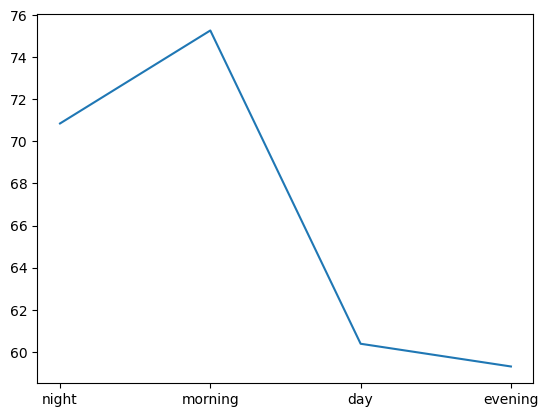


Average atmospheric pressure at different times of day


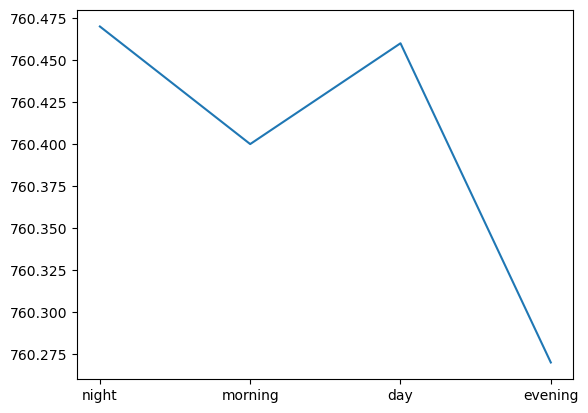


Average temperature at different times of day


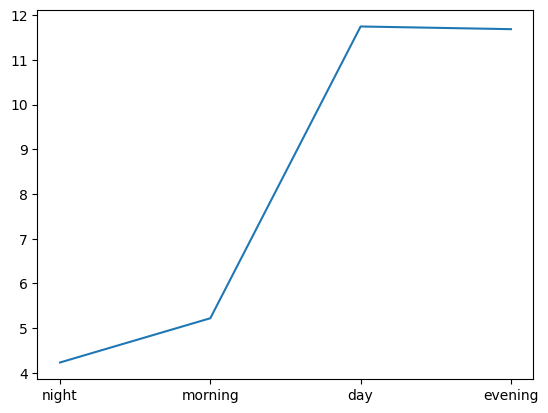

In [193]:
for i in full_labels.keys():
    avg_by_time(i)

Weather distribution at night


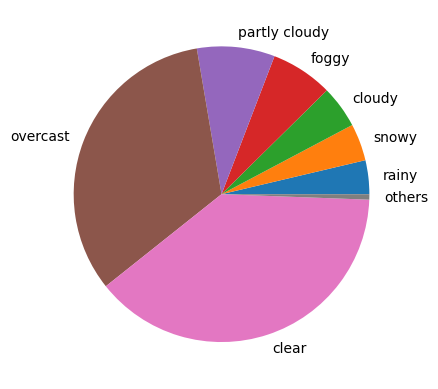


Weather distribution at morning


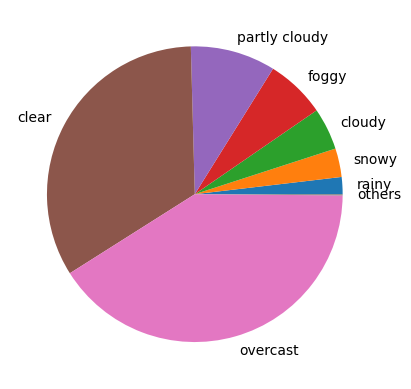


Weather distribution at day


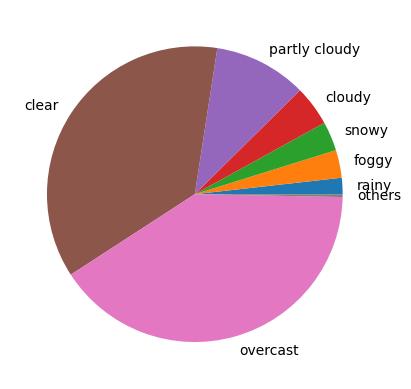


Weather distribution at evening


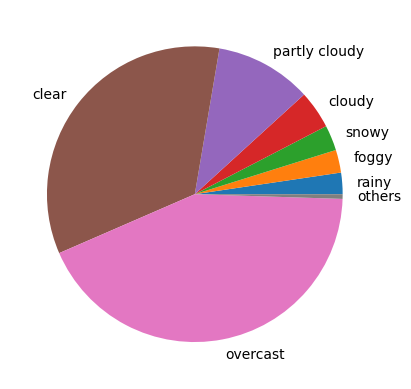

In [194]:
for i in daytimes:
    weather_in_time(i)

Average temperature at day by weather


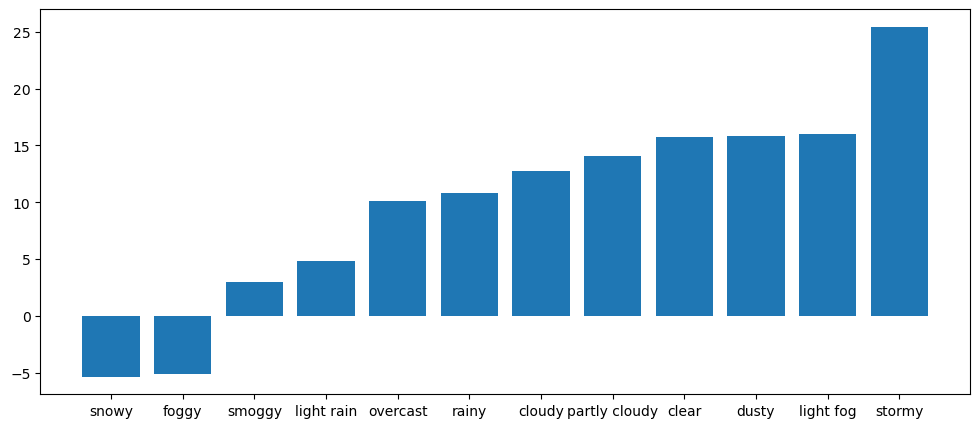

In [195]:
avg_by_weather('temp')

Average humidity at day by weather


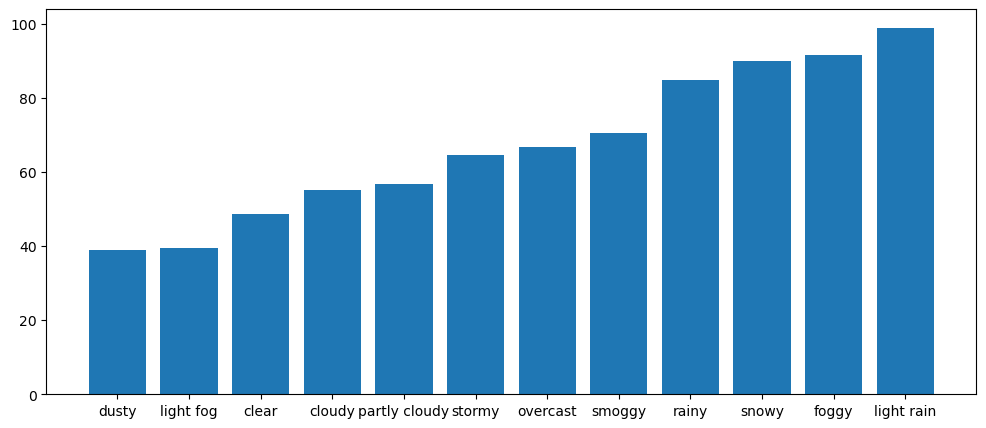

In [196]:
avg_by_weather('hum')

Average humidity at day by year


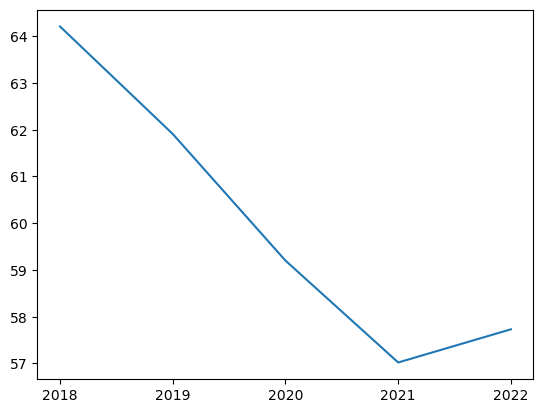

In [224]:
print('Average humidity at day by year')
avg_by_year('hum_day')

Average temperature at day by year


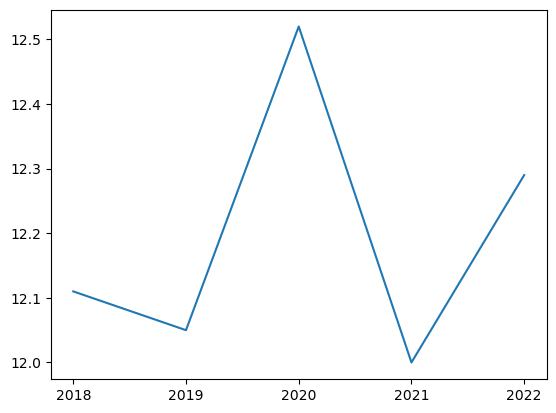

In [225]:
print('Average temperature at day by year')
avg_by_year('temp_day')

Average humidity at day by city


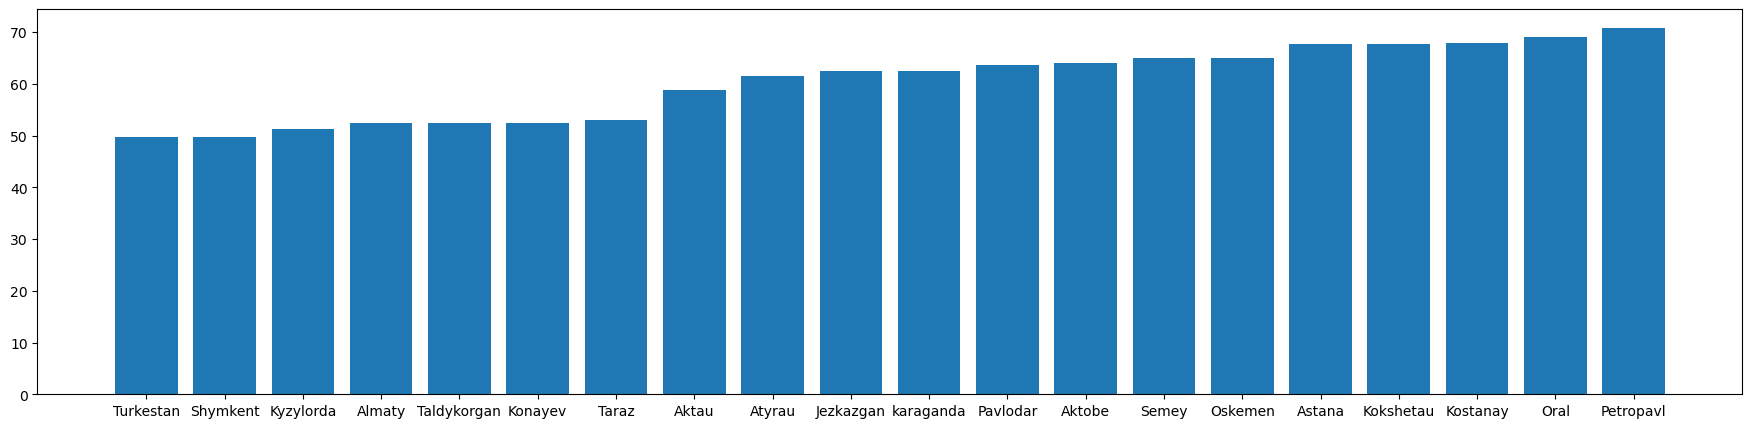

In [221]:
print('Average humidity at day by city')
avg_by_city('hum_day')

Average humidity by cities at different times of day

Average temperature at day by city


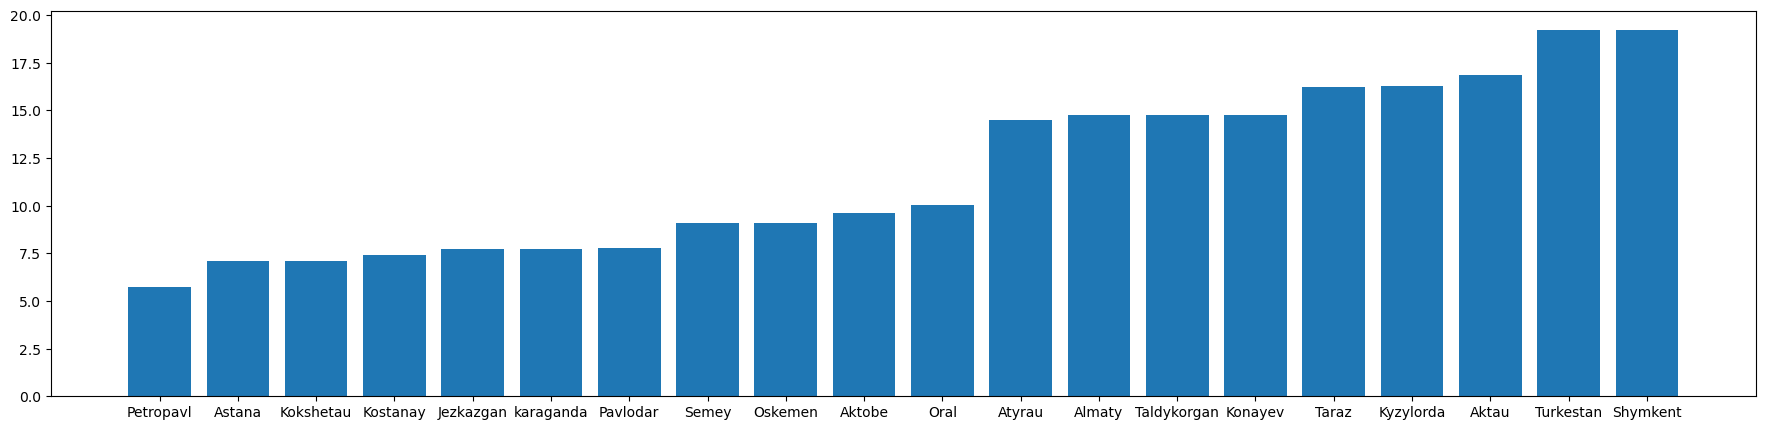

In [222]:
print('Average temperature at day by city')
avg_by_city('temp_day')

In [235]:
def avg_by_month(param: str):
    temp = df.select('month', param).groupBy('month').agg(round(avg(param), 2).alias('AVG')).orderBy('month').toPandas()
    fig = plt.figure(figsize = (22, 5))
    plt.bar(temp['month'], temp['AVG'])
    plt.show()

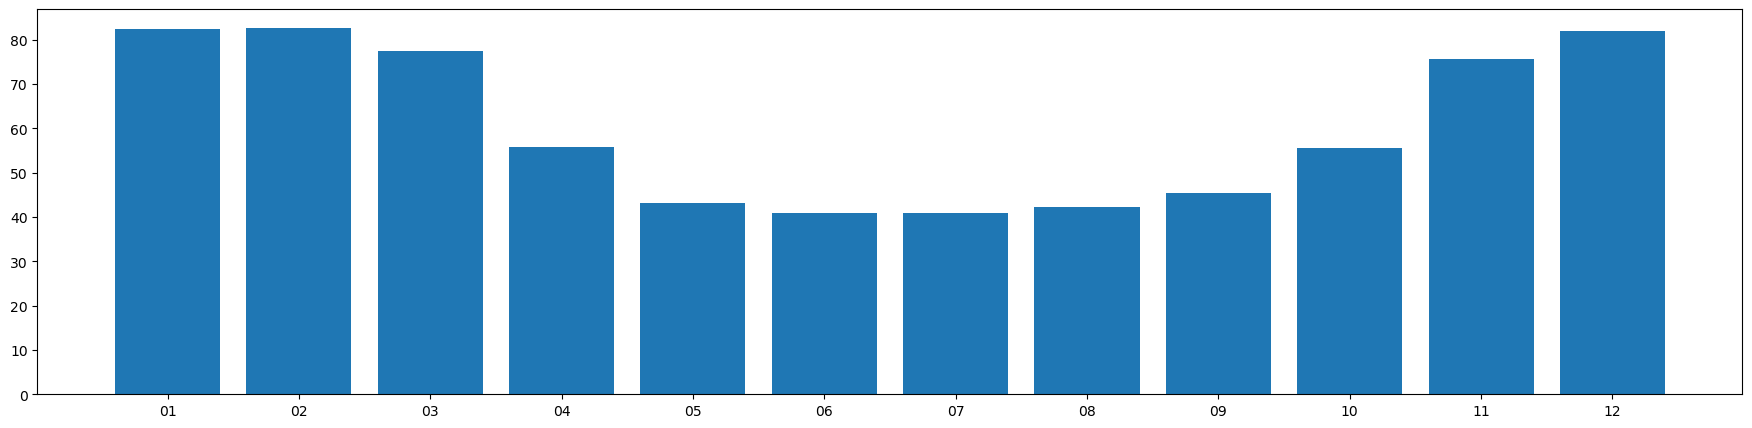

In [236]:
avg_by_month('hum_day')

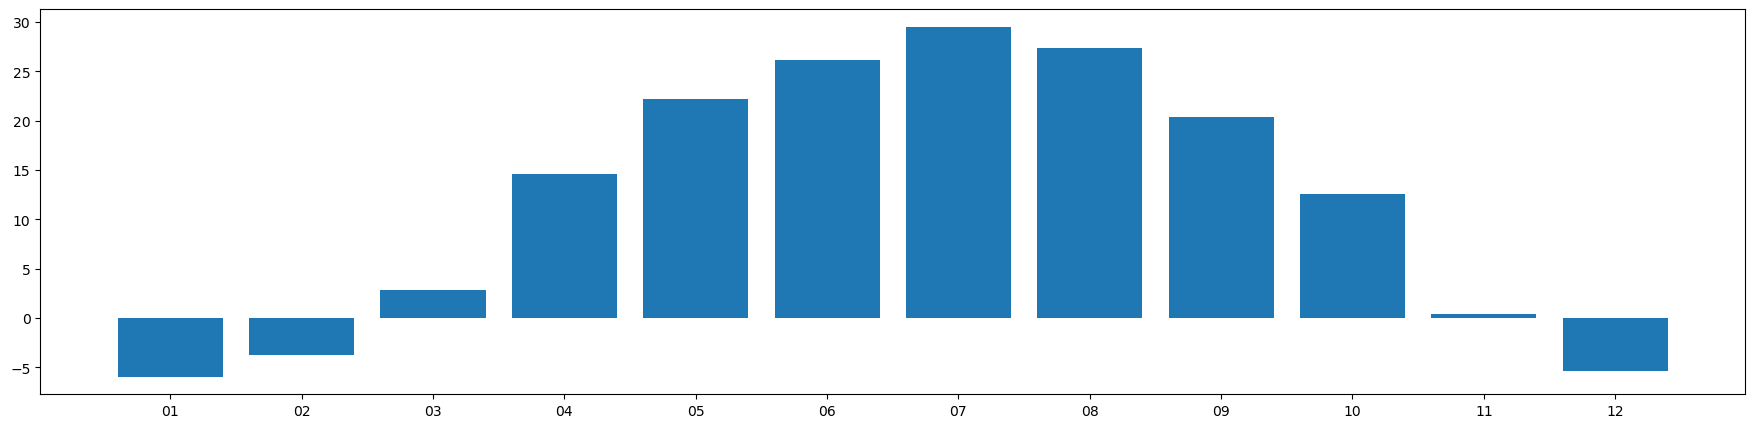

In [237]:
avg_by_month('temp_day')